# **Store Sales** 🏪

In this notebook, predictive business analytics study is performed on a Kaggle data set which consists of store sales and other relevant information.

The breakdown of the study is as below:

<ul>
<li>Data exploration</li>
<li>Data transformation</li>
<li>Feature selection</li>
<li>Model construction</li>
<li>Performance evaluation</li>
<li>Model improvement</li>
</ul>

Data Source: "https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data"

In [2]:
import warnings
import numpy as numpy
import pandas as pandas
import matplotlib.pyplot as pyplot
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from scipy.stats import f_oneway
from xgboost import XGBRegressor
from xgboost import cv
import optuna

In [3]:
warnings.filterwarnings('ignore')
pandas.set_option('display.max_columns', None)
pandas.set_option('display.max_rows', None)

### **Data Exploration**

<ul>
<li>Extract data from each source file</li>
<li>Merge raw data files on appropriate key columns in order to create a main data set</li>
<li>View sample from data set</li>
<li>Get information about data set</li>
<li>Count the number of unique values for each column</li>
<li>Classify variables with the help of business case, viewed sample, data type information and number of unique values</li>
<li>Make descriptive analysis on target variable</li>
</ul>

In [4]:
Train = pandas.read_csv('train.csv')
Stores = pandas.read_csv('stores.csv')
HolidaysEvents = pandas.read_csv('holidays_events.csv')
Oil = pandas.read_csv('oil.csv')
Transactions = pandas.read_csv('transactions.csv')
DataSet = pandas.DataFrame()

DataSet = Train
DataSet = pandas.merge(DataSet, Stores, on="store_nbr", how='inner')
DataSet = pandas.merge(DataSet, HolidaysEvents, on="date", how='left')
DataSet = pandas.merge(DataSet, Oil, on="date", how='left')
DataSet = pandas.merge(DataSet, Transactions, on=['date', 'store_nbr'], how='left')
DataSet.rename(columns= {'type_x': 'store_type'}, inplace = True)
DataSet.rename(columns= {'type_y': 'holiday_type'}, inplace = True)

DataSet.sample(5)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,holiday_type,locale,locale_name,description,transferred,dcoilwtico,transactions
2359024,2316256,2016-07-26,49,LADIESWEAR,14.0,0,Quito,Pichincha,A,11,NaN,NaN,NaN,NaN,NaN,42.16,2399.0
591414,584286,2013-11-24,52,LINGERIE,0.0,0,Manta,Manabi,A,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN
161467,161467,2013-04-01,39,SCHOOL AND OFFICE SUPPLIES,0.0,0,Cuenca,Azuay,B,6,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False,97.10,1466.0
706288,697378,2014-01-28,26,"LIQUOR,WINE,BEER",15.0,0,Guayaquil,Guayas,D,10,NaN,NaN,NaN,NaN,NaN,97.49,557.0
1864151,1839203,2015-11-01,14,HARDWARE,0.0,0,Riobamba,Chimborazo,C,7,NaN,NaN,NaN,NaN,NaN,NaN,943.0


In [5]:
DataSet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            3054348 non-null  int64  
 1   date          3054348 non-null  object 
 2   store_nbr     3054348 non-null  int64  
 3   family        3054348 non-null  object 
 4   sales         3054348 non-null  float64
 5   onpromotion   3054348 non-null  int64  
 6   city          3054348 non-null  object 
 7   state         3054348 non-null  object 
 8   store_type    3054348 non-null  object 
 9   cluster       3054348 non-null  int64  
 10  holiday_type  502524 non-null   object 
 11  locale        502524 non-null   object 
 12  locale_name   502524 non-null   object 
 13  description   502524 non-null   object 
 14  transferred   502524 non-null   object 
 15  dcoilwtico    2099196 non-null  float64
 16  transactions  2805231 non-null  float64
dtypes: float64(3), int64(4), ob

In [6]:
DataSet.nunique()

id              3000888
date               1684
store_nbr            54
family               33
sales            379610
onpromotion         362
city                 22
state                16
store_type            5
cluster              17
holiday_type          6
locale                3
locale_name          24
description         101
transferred           2
dcoilwtico          994
transactions       4993
dtype: int64

In [7]:
TargetVariable = 'sales'
CategoricalVariables = ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster', 'holiday_type', 'locale', 'locale_name', 'description']
ContinuousVariables = ['onpromotion', 'dcoilwtico', 'transactions']

count    3.054348e+06
mean     3.590209e+02
std      1.107286e+03
min      0.000000e+00
25%      0.000000e+00
50%      1.100000e+01
75%      1.960110e+02
max      1.247170e+05
Name: sales, dtype: float64

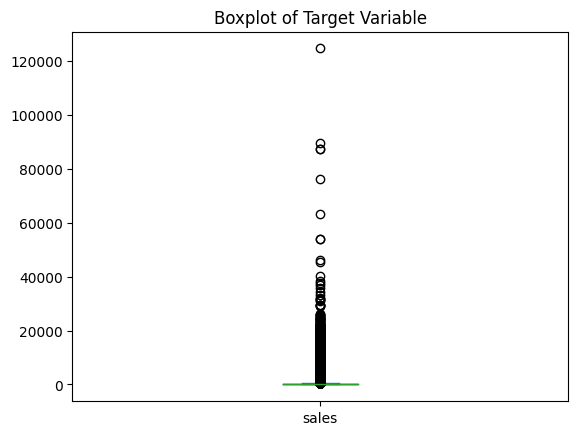

In [8]:
DataSet[TargetVariable].plot(kind='box', title='Boxplot of Target Variable')
DataSet[TargetVariable].describe()

### **Data Transformation**

<ul>
<li>Treat outliers in target variable with the mean value</li>
    <ul>
    <li>Earthquake on April 16, 2016</li>
    <li>Outside of %75 quantile</li>
    </ul>
<li>Fill the missing values with the mean value of each continuous column in data set</li>
<li>Fill the missing values as "None" of each categorical column (Missing values caused by non-holiday days)</li>
<li>Set the data type of categorical variables</li>
<li>Use ordinal encoding to process the values of categorical values to make feature selection and statistical testing properly</li>
<li>View sample from transformed data set</li>
<li>Get information about transformed data set</li>
<li>Make descriptive analysis on target variable to see the effect of outlier treatment</li>
</ul>

In [9]:
DataSet['sales'][(DataSet['date'] > '2016-04-16') & (DataSet['date'] < '2016-06-16')] = DataSet['sales'].mean()
DataSet['sales'][(DataSet['sales'] > DataSet['sales'].quantile(q=0.75))] = DataSet['sales'].mean()
DataSet['dcoilwtico'].fillna(DataSet['dcoilwtico'].mean(), inplace=True)
DataSet['transactions'].fillna(DataSet['transactions'].mean(), inplace=True)
DataSet['holiday_type'].fillna('None', inplace=True)
DataSet['locale'].fillna('None', inplace=True)
DataSet['locale_name'].fillna('None', inplace=True)
DataSet['description'].fillna('None', inplace=True)
DataSet['transferred'].fillna('None', inplace=True)

for var in CategoricalVariables:
    DataSet[var] = DataSet[var].astype('category')

ordinalEncoder = OrdinalEncoder()
DataSet[CategoricalVariables] = ordinalEncoder.fit_transform(DataSet[CategoricalVariables])

DataSet.sample(5)

,id,date,store_nbr,family,sales,onpromotion,city,state,store_type,cluster,holiday_type,locale,locale_name,description,transferred,dcoilwtico,transactions
329519,324173,2013-07-01,53.0,14.0,1.00000,0,5.0,10.0,2.0,2.0,4.0,2.0,16.0,49.0,None,97.940000,885.0
401981,394853,2013-08-10,37.0,8.0,354.91188,0,12.0,8.0,3.0,3.0,3.0,1.0,4.0,50.0,False,68.015874,2029.0
605586,598458,2013-12-02,49.0,3.0,354.91188,0,0.0,15.0,0.0,13.0,4.0,2.0,16.0,49.0,None,93.610000,2458.0
2425954,2383186,2016-09-02,26.0,25.0,223.00000,3,4.0,6.0,3.0,0.0,4.0,2.0,16.0,49.0,None,44.390000,1524.0
2719306,2672974,2017-02-12,8.0,7.0,354.91188,34,18.0,12.0,1.0,5.0,4.0,2.0,16.0,49.0,None,68.015874,2134.0


In [10]:
DataSet.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3054348 entries, 0 to 3054347
Data columns (total 17 columns):
 #   Column        Non-Null Count    Dtype  
---  ------        --------------    -----  
 0   id            3054348 non-null  int64  
 1   date          3054348 non-null  object 
 2   store_nbr     3054348 non-null  float64
 3   family        3054348 non-null  float64
 4   sales         3054348 non-null  float64
 5   onpromotion   3054348 non-null  int64  
 6   city          3054348 non-null  float64
 7   state         3054348 non-null  float64
 8   store_type    3054348 non-null  float64
 9   cluster       3054348 non-null  float64
 10  holiday_type  3054348 non-null  float64
 11  locale        3054348 non-null  float64
 12  locale_name   3054348 non-null  float64
 13  description   3054348 non-null  float64
 14  transferred   3054348 non-null  object 
 15  dcoilwtico    3054348 non-null  float64
 16  transactions  3054348 non-null  float64
dtypes: float64(13), int64(2), o

count    3.054348e+06
mean     1.123318e+02
std      1.486841e+02
min      0.000000e+00
25%      0.000000e+00
50%      1.300000e+01
75%      2.470000e+02
max      3.549119e+02
Name: sales, dtype: float64

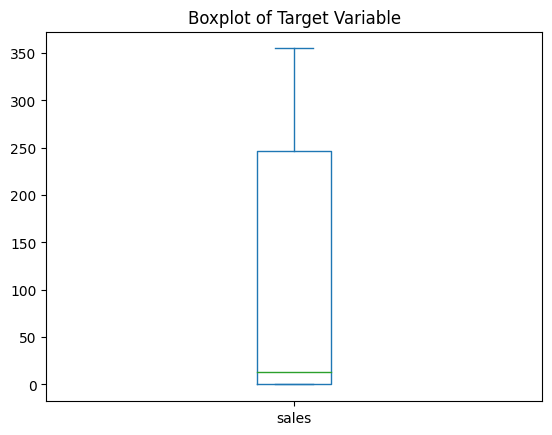

In [11]:
DataSet[TargetVariable].plot(kind='box', title='Boxplot of Target Variable')
DataSet[TargetVariable].describe()

### **Feature Selection**

Target variable of this study is continuous and there is both categorical and continuous variables among candidate features. During feature selection step, we have to seek for a variation of the pattern between target variable and candidate features. Visualization methods can help us to make investigation however the relationship between variables should be statistically proven.

<ul>
<li> Investigate the relationship between target variable and categorical variables
    <ul>
    <li>Plot a bar chart of each variable for visual evaluation</li>
    <li>Perform ANOVA Test for statistical evaluation</li>
    </ul>
</li>
<li> Investigate the relationship between target variable and continuous variables
    <ul>
    <li>Create a correlation matrix to measure the relationship</li>
    <li>Visualize the correlation matrix to make interpretations</li>
    </ul>
</li>
</ul>

store_nbr is related with target variable
P Value: 0.0
family is related with target variable
P Value: 0.0
city is related with target variable
P Value: 0.0
state is related with target variable
P Value: 0.0
store_type is related with target variable
P Value: 0.0
cluster is related with target variable
P Value: 0.0
holiday_type is related with target variable
P Value: 0.0
locale is related with target variable
P Value: 0.0
locale_name is related with target variable
P Value: 0.0
description is related with target variable
P Value: 0.0


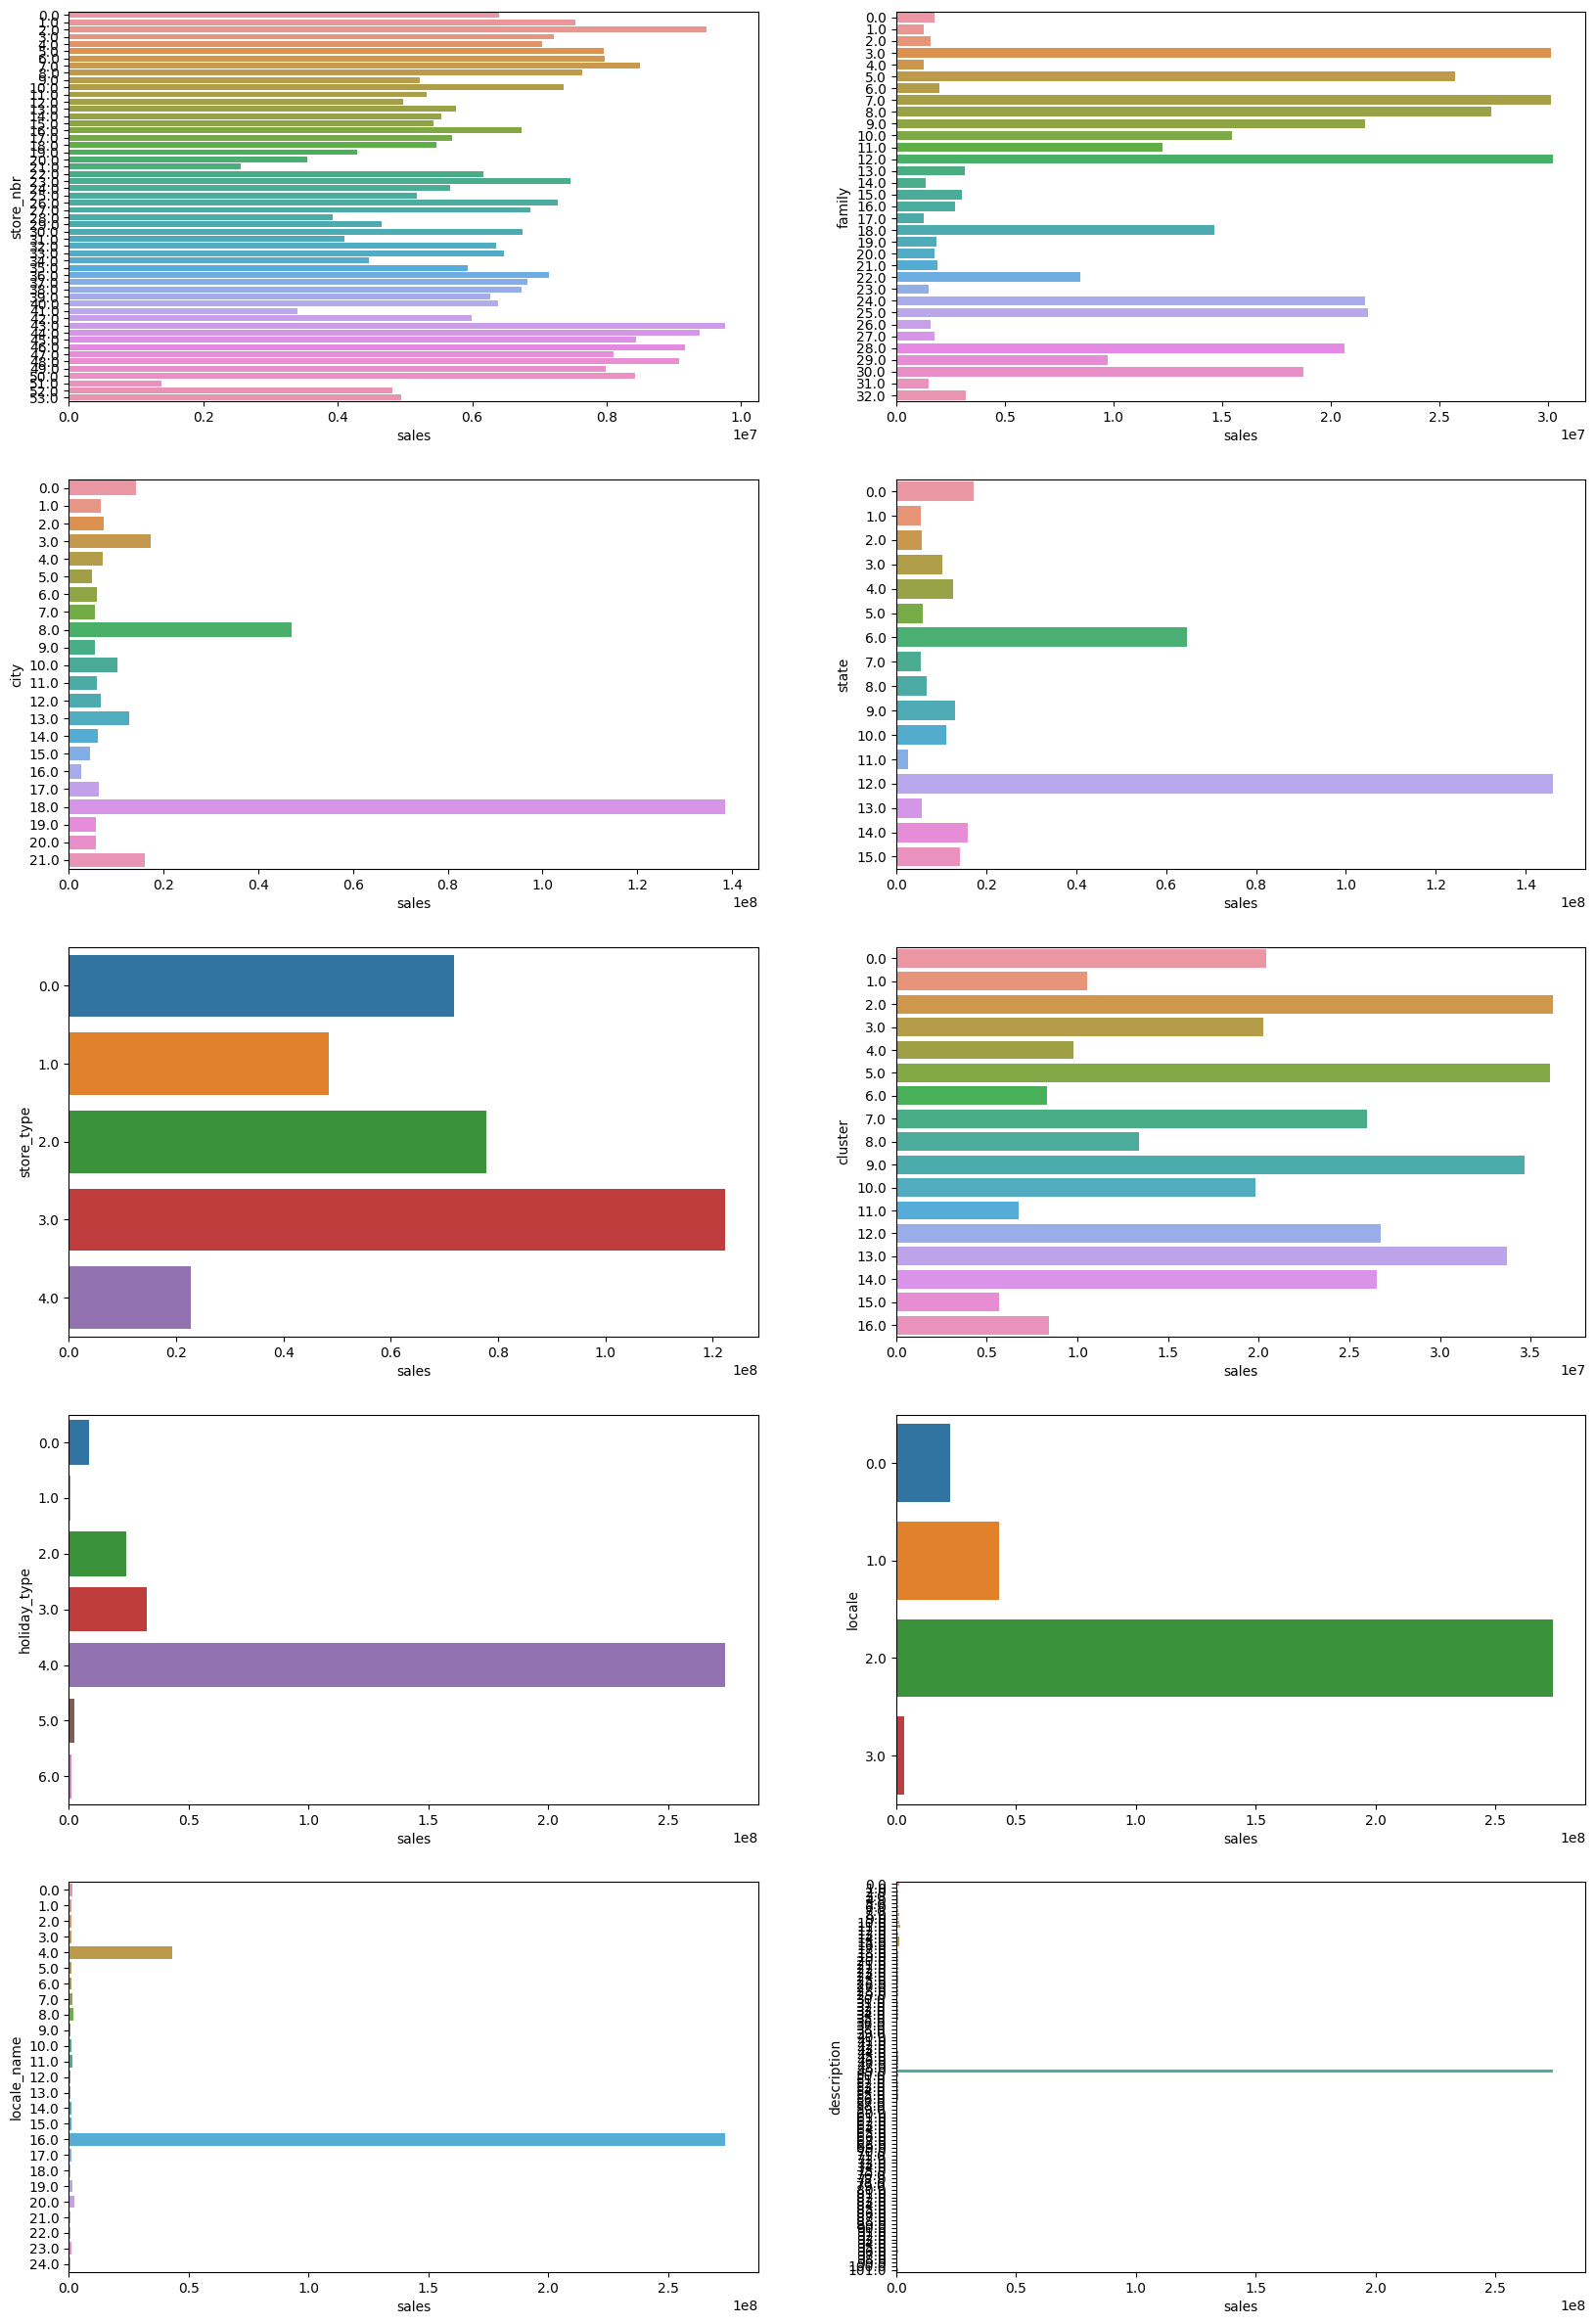

In [12]:
fig, axs = pyplot.subplots(nrows=5, ncols=2, figsize=(20, 30))

for var, ax in zip(CategoricalVariables, axs.ravel()):
    SalesByCategory = DataSet.groupby(var)[TargetVariable].sum().reset_index()
    sns.barplot(data=SalesByCategory, x=TargetVariable, y=var, ax=ax, orient='h')
    
    AnovaTest = f_oneway(DataSet[TargetVariable], DataSet[var])
    if (AnovaTest[1] < 0.05):
        print(var, "is related with target variable\nP Value:", AnovaTest[1])
    else:
        print(var, "is NOT related with target variable\nP Value:", AnovaTest[1])

pyplot.show()

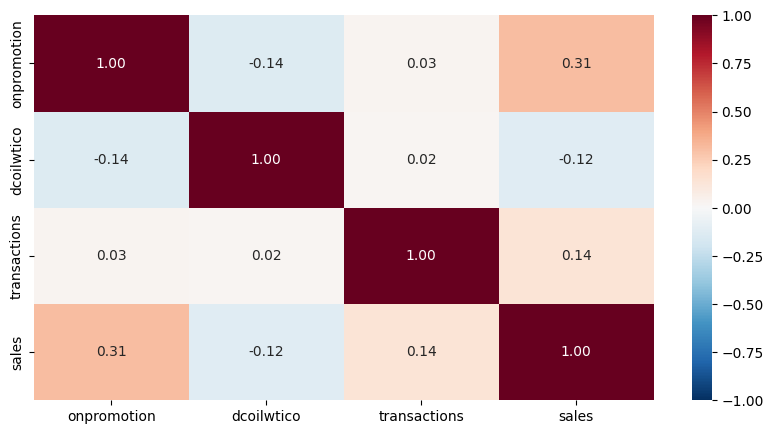

In [13]:
CorrelationData = DataSet[ContinuousVariables]
CorrelationData[TargetVariable] = DataSet[TargetVariable]
CorrelationMatrix = CorrelationData.corr()
CorrelationMatrix

pyplot.figure(figsize=(10,5))

mask = numpy.triu(numpy.ones_like(CorrelationMatrix, dtype=bool))

sns.heatmap(CorrelationMatrix,
            cmap='RdBu_r',
            annot=True,
            fmt='.2f',
            vmin=-1, vmax=1)

pyplot.show()

### **XGBoost**

XGBoost is an appropriate algorithm to solve this problem.

<ul>
<li>Set predictor variables after feature selection</li>
<li>Split data set into train and test</li>
<li>Build a base model and make predictions</li>
<li>Evaluate model performance</li>
<li>Perform hyperparameter tuning with Optuna Framework</li>
<li>Rebuild model with best hyperparameters</li>
<li>View sample from actual and predicted values</li>
</ul>

In [14]:
PredictorVariables = ['store_nbr', 'family', 'city', 'state', 'store_type', 'cluster', 'holiday_type', 'locale', 'locale_name', 'description', 'onpromotion', 'dcoilwtico', 'transactions']

X = DataSet[PredictorVariables]
Y = DataSet[TargetVariable]

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state=42)

XGBoostModel = XGBRegressor(enable_categorical=True)

XGBoostModel.fit(X_train, Y_train)

Y_pred = XGBoostModel.predict(X_test)

print("--- Performance ---")
print("Mean Absolute Error: ", metrics.mean_absolute_error(Y_test, Y_pred))

--- Performance ---
Mean Absolute Error:  28.231541780153524


In [15]:
def objective(trial):
    
    parameters = {
        'learning_rate': trial.suggest_categorical('learning_rate', [0.1, 0.2, 0.3, 0.4, 0.5]),
        'gamma': trial.suggest_float('gamma', 0, 1.1),
        'lambda': trial.suggest_float('lambda', 0, 1.1),
        'alpha': trial.suggest_float('alpha', 0, 1.1),
        'max_depth': trial.suggest_categorical('max_depth', [4, 6, 8, 10]),
        'n_estimators': trial.suggest_categorical('n_estimators', [50, 100, 150, 200]),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'random_state': trial.suggest_categorical('random_state', [42]),
        'objective': trial.suggest_categorical('objective', ['reg:absoluteerror']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['mae']),
        'gpu_id': trial.suggest_categorical('gpu_id', [1]),
        'enable_categorical': trial.suggest_categorical('enable_categorical', [True])
    }

    optunaModel = XGBRegressor(**parameters)
    
    optunaModel.fit(X_train, Y_train)
    
    Y_pred = optunaModel.predict(X_test)

    return metrics.mean_absolute_error(Y_test, Y_pred)

study = optuna.create_study(study_name='Store_Sales' ,direction='minimize')
study.optimize(objective, n_trials=10)

XGBoostModel = XGBRegressor(**study.best_trial.params)

XGBoostModel.fit(X_train, Y_train)

Y_pred = XGBoostModel.predict(X_test)

print("\nBest Hyperparameters\n", study.best_trial.params)
print("\n--- Performance (After Tuning) ---")
print("Mean Absolute Error: ", metrics.mean_absolute_error(Y_test, Y_pred))

[I 2024-11-28 20:46:07,561] A new study created in memory with name: Store_Sales
[I 2024-11-28 20:46:26,480] Trial 0 finished with value: 55.44275083695412 and parameters: {'learning_rate': 0.1, 'gamma': 0.22140745769570755, 'lambda': 0.37194288920586766, 'alpha': 0.025273606596490073, 'max_depth': 4, 'n_estimators': 50, 'min_child_weight': 7, 'random_state': 42, 'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'gpu_id': 1, 'enable_categorical': True}. Best is trial 0 with value: 55.44275083695412.
[I 2024-11-28 20:47:12,703] Trial 1 finished with value: 20.53863051065953 and parameters: {'learning_rate': 0.4, 'gamma': 0.34418455602699466, 'lambda': 0.8718632395124072, 'alpha': 0.5024846371705906, 'max_depth': 10, 'n_estimators': 150, 'min_child_weight': 3, 'random_state': 42, 'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'gpu_id': 1, 'enable_categorical': True}. Best is trial 1 with value: 20.53863051065953.
[I 2024-11-28 20:47:54,351] Trial 2 finished with value: 19.


Best Hyperparameters
 {'learning_rate': 0.5, 'gamma': 0.3101045748146132, 'lambda': 0.01660805966524679, 'alpha': 0.7619606729706592, 'max_depth': 10, 'n_estimators': 150, 'min_child_weight': 1, 'random_state': 42, 'objective': 'reg:absoluteerror', 'eval_metric': 'mae', 'gpu_id': 1, 'enable_categorical': True}

--- Performance (After Tuning) ---
Mean Absolute Error:  19.742777753862853


In [16]:
ResultsDataFrame = pandas.DataFrame({'Actual Data' : Y_test.squeeze(), 'Predicted Data' : Y_pred.squeeze()})
ResultsDataFrame.sample(50)

,Actual Data,Predicted Data
2193594,354.91188,355.369995
1537844,45.00000,151.375977
455078,354.91188,261.151062
2607458,125.60100,128.662354
2423441,16.00000,21.811945
2819989,354.91188,354.911102
814903,0.00000,0.000000
1537267,178.27900,165.900497
2546270,0.00000,0.500000
74622,0.00000,0.000000


In [17]:
Test = pandas.read_csv('test.csv')
SubmissionDataSet = pandas.DataFrame()

SubmissionDataSet = Test
SubmissionDataSet = pandas.merge(SubmissionDataSet, Stores, on="store_nbr", how='inner')
SubmissionDataSet = pandas.merge(SubmissionDataSet, HolidaysEvents, on="date", how='left')
SubmissionDataSet = pandas.merge(SubmissionDataSet, Oil, on="date", how='left')
SubmissionDataSet = pandas.merge(SubmissionDataSet, Transactions, on=['date', 'store_nbr'], how='left')
SubmissionDataSet.rename(columns= {'type_x': 'store_type'}, inplace = True)
SubmissionDataSet.rename(columns= {'type_y': 'holiday_type'}, inplace = True)

SubmissionDataSet['dcoilwtico'].fillna(SubmissionDataSet['dcoilwtico'].mean(), inplace=True)
SubmissionDataSet['transactions'].fillna(SubmissionDataSet['transactions'].mean(), inplace=True)

for var in CategoricalVariables:
    SubmissionDataSet[var] = SubmissionDataSet[var].astype('category')

X_submission = SubmissionDataSet[PredictorVariables]
Y_submission = XGBoostModel.predict(X_submission)

Submission = pandas.DataFrame({'id': SubmissionDataSet.id, 'sales': Y_submission})
Submission.to_csv('Submission.csv', index=False)